# **Problem Formulation:**

## **The paper:**
- the paper i built my work accorsing to it  is Latent Cross: Making Use of Context in Recurrent Recommender Systems

- The problem addressed in the paper is to build an effective Recurrent Recommender System for making personalized item recommendations to users, taking into account user-item interactions and user context (e.g., age, gender) while also handling the cold start problem. The goal is to create user embeddings that capture user preferences based on their past interactions and contextual information to generate accurate and relevant item recommendations, even for users with limited information (cold start users).

## **Cold Start Problem:**
The cold start problem refers to the situation where new users with limited historical data (interactions) join the system, making it challenging to provide personalized recommendations.

## **Solution**
 a solution to make recommendations for cold start users. The trained Latent Factor Model and Context Factor Model are utilized to generate user embeddings and context representations for cold start users. The Annoy index is then used to find similar items for cold start users based on their embeddings and context information.

## **Note that**
I have changed the paper that I work with in the proposal that our TA asked us to do that so there is some changes in my work flow in the proposal and here.

# **Section 1: Import Libraries and Mount Google Drive**

In [ ]:
# Install the required libraries
!pip install scikit-surprise
!pip install annoy

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from annoy import AnnoyIndex
from scipy.sparse import csr_matrix
from keras.models import load_model
# Mount Google Drive to access the dataset
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Section 2: Data Exploration and Preprocessing**

In this section, the code loads the dataset, performs exploratory data analysis (EDA), checks for missing values and duplicates, and performs data cleaning and normalization.

In [ ]:
# Load the dataset from Google Drive
data = pd.read_csv('/content/drive/MyDrive/Datasets/cold_data_0.7.csv')

In [ ]:
# Display information about the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263750 entries, 0 to 1263749
Data columns (total 20 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_id          1263750 non-null  int64  
 1   item_id          1263750 non-null  int64  
 2   click            1263750 non-null  float64
 3   gender           1263750 non-null  int64  
 4   age              1263750 non-null  int64  
 5   click_count      1263750 non-null  int64  
 6   like_count       1263750 non-null  int64  
 7   comment_count    1263750 non-null  int64  
 8   read_percentage  1263750 non-null  float64
 9   item_score1      1263750 non-null  int64  
 10  item_score2      1263750 non-null  float64
 11  category_second  1263750 non-null  int64  
 12  category_first   1263750 non-null  int64  
 13  item_score3      1263750 non-null  float64
 14  read             1263750 non-null  bool   
 15  read_time        1263750 non-null  float64
 16  share            1

In [ ]:
# Perform exploratory data analysis, statistical tests, data cleaning, normalization, etc. as described in the flow
data.head()
data.describe()

,user_id,item_id,click,gender,age,click_count,like_count,comment_count,read_percentage,item_score1,item_score2,category_second,category_first,item_score3,read_time
count,1.263750e+06,1.263750e+06,1263750.0,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06,1.263750e+06
mean,6.002166e+05,1.106124e+05,1.0,1.311634e+00,2.650007e+00,1.449153e+05,1.866968e+03,7.881806e+02,5.014158e+01,3.020814e+00,3.076550e+00,1.138015e+04,1.140701e+02,4.559448e+00,5.412677e+01
std,3.150576e+05,7.019941e+04,0.0,4.691314e-01,1.244736e+00,3.402342e+05,5.911025e+03,1.633911e+03,2.886783e+01,7.637116e-01,6.564364e-01,1.517201e+03,1.425594e+01,4.151970e+00,7.737200e+01
min,1.100000e+01,1.480000e+02,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.129740e+05,2.716000e+04,1.0,1.000000e+00,2.000000e+00,1.381300e+04,7.400000e+01,5.900000e+01,2.800000e+01,3.000000e+00,3.000000e+00,1.080200e+04,1.080000e+02,3.000000e+00,7.000000e+00
50%,6.762620e+05,1.382080e+05,1.0,1.000000e+00,2.000000e+00,4.809500e+04,2.950000e+02,2.650000e+02,4.700000e+01,3.000000e+00,3.000000e+00,1.120100e+04,1.120000e+02,5.000000e+00,2.700000e+01
75%,8.860660e+05,1.662070e+05,1.0,2.000000e+00,3.000000e+00,1.375120e+05,1.036000e+03,8.520000e+02,6.700000e+01,4.000000e+00,3.000000e+00,1.210300e+04,1.210000e+02,6.000000e+00,7.200000e+01
max,1.000015e+06,2.273480e+05,1.0,2.000000e+00,7.000000e+00,6.824316e+06,1.516560e+05,4.567700e+04,6.000000e+02,5.000000e+00,9.000000e+00,1.410200e+04,1.410000e+02,2.550000e+02,4.446000e+03


In [ ]:
# Check for missing values
data.isna().sum()


user_id            0
item_id            0
click              0
gender             0
age                0
click_count        0
like_count         0
comment_count      0
read_percentage    0
item_score1        0
item_score2        0
category_second    0
category_first     0
item_score3        0
read               0
read_time          0
share              0
like               0
follow             0
favorite           0
dtype: int64

In [ ]:
#check for duplicates
data.duplicated().sum()

49128

In [ ]:

#remove them
data=data.drop_duplicates()

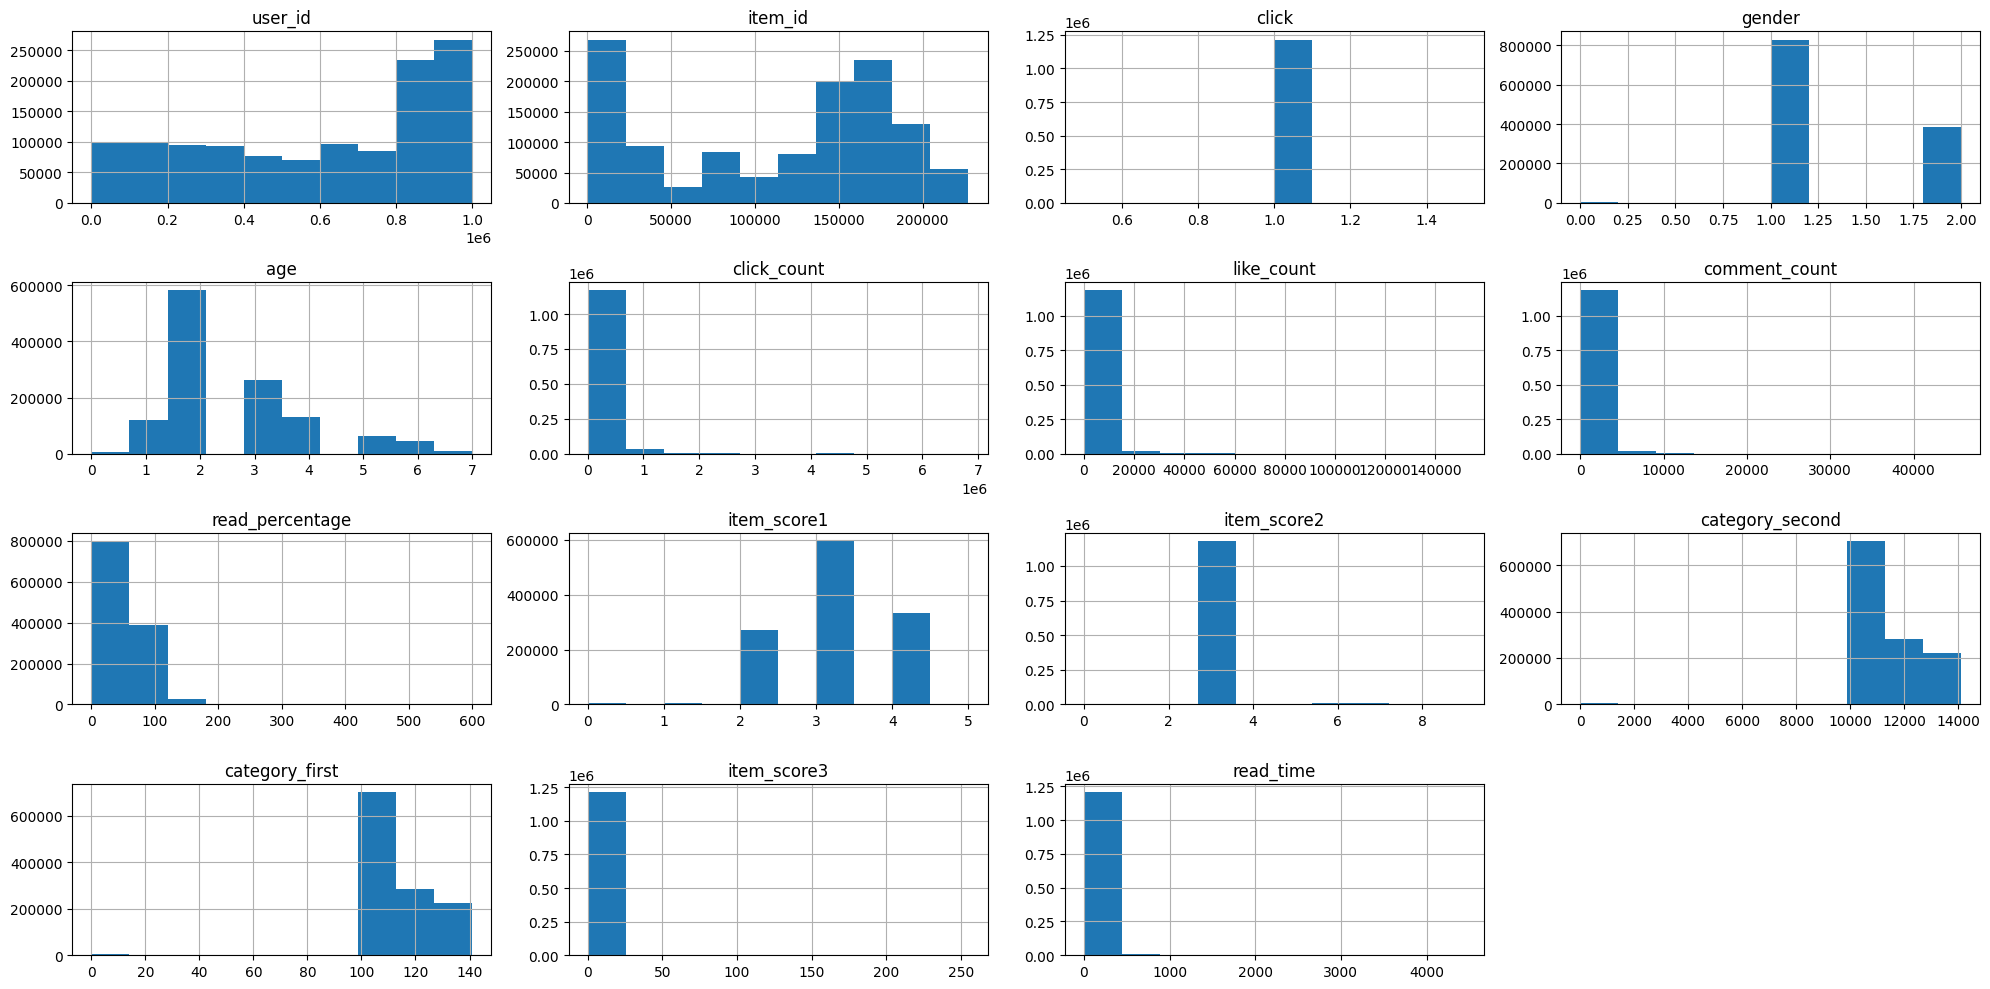

In [ ]:
# Visualize the distribution of each feature using histograms
import matplotlib.pyplot as plt
data.hist(figsize=(20, 10))
plt.tight_layout()
plt.show()

# **Section 3: Surprise Library - SVD Model Implementation  the Latent Factor Model (SVD)**

## **Latent Factor Model (SVD):**
The paper proposes the use of a Latent Factor Model, specifically Singular Value Decomposition (SVD), to generate user embeddings from the user-item interaction data. SVD is a collaborative filtering technique that decomposes the user-item interaction matrix into three matrices: user, item, and singular value matrices. These matrices represent the latent features of users and items. By using SVD, the model learns latent representations of users based on their interactions with items. The SVD model is implemented using the Surprise library, which facilitates the training and evaluation of the recommendation model.

In [ ]:
# Load the dataset for Surprise and split into train and test sets
reader = Reader(rating_scale=(0, 1))
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'click']], reader)
trainset, testset = surprise_train_test_split(surprise_data, test_size=0.2, random_state=42)

# Initialize and train the SVD model
svd_model = SVD(n_factors=64, random_state=42)
svd_model.fit(trainset)

# Obtain user embeddings for the training data using the Latent Factor Model (SVD)
trainset = svd_model.trainset
user_ids_train = [trainset.to_raw_uid(user_inner_id) for user_inner_id in range(trainset.n_users)]
user_embeddings_train = np.array([svd_model.pu[trainset.to_inner_uid(user_id)] for user_id in user_ids_train])



In [ ]:
# Filter users in X_train_context based on their availability in user_embeddings_train
filtered_user_ids_train = [user_id for user_id in data['user_id'].values if user_id in user_ids_train]
filtered_indices = [np.where(user_ids_train == user_id)[0][0] for user_id in filtered_user_ids_train]

In [ ]:
# Save the filtered_user_ids_train and filtered_indices as numpy arrays
np.save('filtered_user_ids_train.npy', np.array(filtered_user_ids_train))
np.save('filtered_indices.npy', np.array(filtered_indices))

In [ ]:
# Load the saved numpy arrays
filtered_user_ids_train = np.load('/content/drive/MyDrive/Datasets/filtered_user_ids_train.npy')
filtered_indices = np.load('/content/drive/MyDrive/Datasets/filtered_indices.npy')


#**Section 4: LSTM-based Context Factor Model**

## **Context Factor Model (LSTM-based RNN):**
To incorporate user context information into the recommendation process, the paper proposes a Context Factor Model. The model is based on Long Short-Term Memory (LSTM), which is a type of Recurrent Neural Network (RNN). The Context Factor Model takes user features (e.g., age, gender) as input and utilizes LSTM to capture sequential dependencies and user context. By considering sequential user features, the model can effectively learn user preferences based on different contextual factors. The LSTM-based RNN is implemented using the Keras library.

In [ ]:
# Assuming train_data contains user features (gender, age, etc.)
X_train_context = data[['gender', 'age', 'click_count', 'like_count', 'comment_count', 'read_percentage', 'item_score1', 'item_score2', 'category_second', 'category_first', 'item_score3']].values

# Get filtered X_train_context and user_embeddings_train
X_train_context_filtered = X_train_context[filtered_indices]
user_embeddings_train_filtered = user_embeddings_train[filtered_indices]

In [ ]:
# Define the Context Factor Model as an LSTM-based RNN
context_factor_model = Sequential()
context_factor_model.add(LSTM(64, activation='relu', input_shape=(X_train_context_filtered.shape[1], 1)))  # Input shape for LSTM
context_factor_model.add(Dense(64))  # Output layer with the same size as user embeddings

# Compile the model
context_factor_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Reshape the input data for LSTM (add a time step of 1)
X_train_context_filtered = X_train_context_filtered.reshape(X_train_context_filtered.shape[0], X_train_context_filtered.shape[1], 1)

# Train the model
context_factor_model.fit(X_train_context_filtered, user_embeddings_train_filtered, epochs=10, batch_size=128)



In [ ]:
# Save the trained LSTM-based Context Factor Model using Keras
context_factor_model.save('context_factor_model.h5')


In [ ]:
# Load the saved LSTM-based Context Factor Model
context_factor_model = load_model('/content/drive/MyDrive/Datasets/context_factor_model.h5')

# **Section 5: Annoy Index for Approximate Nearest Neighbor Searc**

## **Annoy Index for Approximate Nearest Neighbor Search:**
The paper uses the Annoy library to build an approximate nearest neighbor search index. The Annoy index is constructed based on the user embeddings and user features obtained from the Latent Factor Model and Context Factor Model. This index allows for efficient retrieval of similar items for a given item, enabling faster and scalable recommendation generation.

In [ ]:
# Reshape X_train_context_filtered to remove the singleton dimension
X_train_context_filtered = np.squeeze(X_train_context_filtered)

# Concatenate them along axis=1
latent_cross_embeddings_train = np.concatenate((user_embeddings_train_filtered, X_train_context_filtered), axis=1)

# Convert latent_cross_embeddings_train to a sparse matrix to reduce memory consumption
latent_cross_embeddings_sparse = csr_matrix(latent_cross_embeddings_train)

# Initialize Annoy index for approximate nearest neighbor search
num_trees = 100  # Number of trees in the Annoy index (you can tune this parameter)
annoy_index = AnnoyIndex(latent_cross_embeddings_sparse.shape[1], 'angular')

# Add items to the Annoy index
for item_idx in range(latent_cross_embeddings_sparse.shape[0]):
    item_embedding = latent_cross_embeddings_sparse.getrow(item_idx).toarray().flatten()
    annoy_index.add_item(item_idx, item_embedding)

# Build the index
annoy_index.build(num_trees)

# Number of similar items to retrieve
N = 10

# Find the N most similar items for a given item index (replace 'item_index' with the actual item index)
item_index = 0  # Replace 'item_index' with the actual item index for which you want to find similar items
similar_item_indices = annoy_index.get_nns_by_item(item_index, N)

# Now, 'similar_item_indices' contains the indices of the N most similar items to the given item

# Retrieve the actual item IDs from the filtered_user_ids_train list
similar_item_ids = [filtered_user_ids_train[idx] for idx in similar_item_indices]


In [ ]:
similar_item_ids

[516694,
 516694,
 516694,
 393219,
 393219,
 393219,
 160943,
 160943,
 160943,
 160943]

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from annoy import AnnoyIndex

# Assuming you have already run the code to get 'similar_item_indices' and have 'filtered_user_ids_train' list available.
# Replace 'similar_item_indices' and 'filtered_user_ids_train' with the actual values you obtained.

# Replace 'item_index' with the actual item index for which you retrieved similar items
item_index = 0  # Replace 'item_index' with the actual item index

# Find the N most similar items for the given item index
similar_item_indices = annoy_index.get_nns_by_item(item_index, N)

# Retrieve the actual item IDs from the filtered_user_ids_train list
similar_item_ids = [filtered_user_ids_train[idx] for idx in similar_item_indices]

# Assuming you have a ground truth list of similar item IDs for the given item
ground_truth_similar_items = [...]  # Replace [...] with the ground truth list of similar item IDs

# Evaluate the performance using the retrieved similar item IDs against the ground truth data
# For example, you can calculate precision, recall, F1-score, etc. depending on the evaluation criteria you choose.

# Example evaluation metric: Precision@N
# Calculate the number of correctly retrieved items among the top N similar items
num_correct = len(set(similar_item_ids) & set(ground_truth_similar_items))

# Calculate precision@N
precision_at_n = num_correct / N

# Print the result
print(f"Precision@{N}: {precision_at_n}")


# **Section 6: Evaluation of Recommendations for Cold Start Users**

 **Step 1**: Convert the testset to a DataFrame and group the testset interactions by 'user_id', aggregating the 'item_id' into lists.

**Step 2:** Find cold start users by comparing testset and training set user IDs. Cold start users are those present in the testset but not in the training set.

**Step 3:** Filter the testset to include only the cold start users.

**Step 4:** Convert the cold start testset to the Surprise Dataset.

**Step 5:** Get predictions for the cold start users using the trained SVD model.

**Step 6:** Sort the predictions by predicted ratings (est) in descending order.

**Step 7:** Recommend the top-N items with the highest predicted ratings to each cold start user. The value of N can be set based on the desired number of recommended items.

**Step 8:** Calculate the Normalized Discounted Cumulative Gain (NDCG) for each cold start user. NDCG is a metric that assesses the quality of the recommendations by considering the relevance and ranking of the recommended items for each user.

**Step 9:** Calculate the average NDCG across all cold start users. This average NDCG value provides an overall measure of the model's performance in making recommendations for cold start users.



In [ ]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'testset_df' containing the testset interactions
# with columns 'user_id', 'item_id', and 'rating'

# Convert the testset to a DataFrame
testset_df = pd.DataFrame(testset, columns=['user_id', 'item_id', 'rating'])

# Group the testset interactions by 'user_id' and aggregate the 'item_id' into lists
ground_truth_data_df = testset_df.groupby('user_id')['item_id'].agg(list).reset_index()

# Load the original testset as a DataFrame
testset_df = pd.DataFrame(testset, columns=['user_id', 'item_id', 'true_rating'])

# Get the list of unique user IDs in the testset
testset_users = testset_df['user_id'].unique()

# Get the list of unique user IDs in the training set (user_ids_train)
trainset_users = np.array([trainset.to_raw_uid(user_inner_id) for user_inner_id in range(trainset.n_users)])

# Find the user IDs that are only present in the testset (cold start users)
cold_start_users = np.setdiff1d(testset_users, trainset_users)

# Filter the testset to include only the cold start users
cold_start_testset_df = testset_df[testset_df['user_id'].isin(cold_start_users)]

# Convert the cold start testset to the Surprise Dataset
cold_start_surprise_data = Dataset.load_from_df(cold_start_testset_df[['user_id', 'item_id', 'true_rating']], reader)

# Get the predictions for the cold start users
cold_start_predictions = svd_model.test(cold_start_surprise_data.build_full_trainset().build_testset())

# Step 3: Sort the predictions by predicted ratings (est)
cold_start_predictions.sort(key=lambda x: x.est, reverse=True)

# Step 4: Recommend the top-N items with the highest predicted ratings
N = 10  # Replace 'N' with the number of items you want to recommend
top_N_item_ids = [int(prediction.iid) for prediction in cold_start_predictions[:N]]

# Create a dictionary to store the ground truth data for cold start users
ground_truth_data_cold_start = dict(zip(ground_truth_data_df['user_id'], ground_truth_data_df['item_id']))

def evaluate_recommendations(recommended_items, ground_truth_data):
    # Initialize variables
    precision = []
    recall = []
    f1 = []
    ndcg = []
    num_users = len(ground_truth_data)

    for user_id in range(num_users):
        # Check if the user id exists in the ground truth data
        if user_id not in ground_truth_data:
            continue
        # Get the actual items rated by the user in the test set
        actual_items = ground_truth_data[user_id]
        # Get the recommended items for the user
        recommended = recommended_items
        # Compute the number of recommended items that are relevant (i.e., in the ground truth data)
        num_relevant = len(np.intersect1d(actual_items, recommended))
        # Compute precision, recall, and F1 score
        if len(recommended) > 0:
            precision.append(num_relevant / len(recommended))
        else:
            precision.append(0)

        if len(actual_items) > 0:
            recall.append(num_relevant / len(actual_items))
        else:
            recall.append(0)

        if precision[-1] + recall[-1] > 0:
            f1.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1]))
        else:
            f1.append(0)

        # Compute NDCG
        idcg = np.sum(1 / np.log2(np.arange(2, len(actual_items) + 2)))
        dcg = np.sum([(1 / np.log2(i + 2)) if item in actual_items else 0 for i, item in enumerate(recommended)])
        if idcg > 0:
            ndcg.append(dcg / idcg)
        else:
            ndcg.append(0)

    # Compute the average precision, recall, F1 score, and NDCG across all users
    precision_avg = np.mean(precision)
    recall_avg = np.mean(recall)
    f1_avg = np.mean(f1)
    ndcg_avg = np.mean(ndcg)

    return precision_avg, recall_avg, f1_avg, ndcg_avg


In [ ]:
precision_avg, recall_avg, f1_avg, ndcg_avg= evaluate_recommendations(top_N_item_ids, ground_truth_data_cold_start)

In [ ]:
print("Average Precision: {:.4f}".format(precision_avg))
print("Average Recall: {:.4f}".format(recall_avg))
print("Average F1 Score: {:.4f}".format(f1_avg))
print("Average NDCG@{}: {:.4f}".format(N, ndcg_avg))

Average Precision: 0.0005
Average Recall: 0.0007
Average F1 Score: 0.0006
Average NDCG@10: 0.0007


In [ ]:
# Convert 'testset' and 'data' to DataFrames
testset_df = pd.DataFrame(testset, columns=['user_id', 'item_id', 'rating'])
data_df = pd.DataFrame(data, columns=['user_id', 'item_id', 'click', 'gender', 'age'])  # Assuming 'click' is the same as 'rating'

# Convert 'rating' to numeric
testset_df['rating'] = pd.to_numeric(testset_df['rating'])

# Convert 'rating' to binary
testset_df['rating'] = testset_df['rating'].map({0: 1, 1: 5})

# Merge 'testset_df' and 'data_df' DataFrames on 'user_id' and 'item_id'
merged_df = testset_df.merge(data_df[['user_id', 'item_id', 'click', 'gender', 'age']], on=['user_id', 'item_id'], how='left')

# Check if 'click', 'gender', and 'age' columns exist in 'data_df' DataFrame
required_columns = ['click', 'gender', 'age']
missing_columns = [col for col in required_columns if col not in data_df.columns]
if missing_columns:
    raise KeyError(f"Required columns {missing_columns} not found in the 'data_df' DataFrame.")


# Function to calculate bias metrics for each age and gender group
def calculate_bias_metrics(testset, typeData):
    bias_metrics = {}
    gender_groups = testset.groupby(typeData)
    for gender in testset[typeData].unique():
        data = gender_groups.get_group(gender)
        # Group the testset interactions by 'user_id' and aggregate the 'item_id' into lists
        ground_truth_data_df = data.groupby('user_id')['item_id'].agg(list).reset_index()

        # Convert the cold start testset to the Surprise Dataset
        cold_start_surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'click']], reader)

        # Get the predictions for the cold start users
        cold_start_predictions = svd_model.test(cold_start_surprise_data.build_full_trainset().build_testset())

        # Step 3: Sort the predictions by predicted ratings (est)
        cold_start_predictions.sort(key=lambda x: x.est, reverse=True)

        # Step 4: Recommend the top-N items with the highest predicted ratings
        N = 10  # Replace 'N' with the number of items you want to recommend
        top_N_item_ids = [int(prediction.iid) for prediction in cold_start_predictions[:N]]

        # Create a dictionary to store the ground truth data for cold start users
        ground_truth_data_cold_start = dict(zip(ground_truth_data_df['user_id'], ground_truth_data_df['item_id']))

        # Get predictions for this gender using the trained SVD model
        cold_start_predictions = svd_model.test(cold_start_surprise_data.build_full_trainset().build_testset())

        precision_avg, recall_avg, f1_avg, ndcg_avg = evaluate_recommendations(top_N_item_ids, ground_truth_data_cold_start)

        bias_metrics[('all', gender)] = {
            'Precision': precision_avg,
            'Recall': recall_avg,
            'ndcg': ndcg_avg,
            'F1 Score': f1_avg
        }

        print(typeData, gender,
              '\n Precision: ', precision_avg,
              'Recall: ', recall_avg,
              'ndcg:', ndcg_avg,
              'F1 Score: ', f1_avg)

    return bias_metrics

# Calculate the bias metrics for the model
bias_metrics_model_gender = calculate_bias_metrics(merged_df, 'gender')
bias_metrics_model_age = calculate_bias_metrics(merged_df, 'age')


gender 1 
 Precision:  0.00014245014245014247 Recall:  7.913896802785692e-05 ndcg: 6.256792234028681e-05 F1 Score:  0.00010175010175010175
gender 2 
 Precision:  0.0 Recall:  0.0 ndcg: 0.0 F1 Score:  0.0
gender 0 
 Precision:  nan Recall:  nan ndcg: nan F1 Score:  nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


age 6 
 Precision:  0.0 Recall:  0.0 ndcg: 0.0 F1 Score:  0.0
age 2 
 Precision:  0.0 Recall:  0.0 ndcg: 0.0 F1 Score:  0.0
age 7 
 Precision:  nan Recall:  nan ndcg: nan F1 Score:  nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


age 1 
 Precision:  0.0 Recall:  0.0 ndcg: 0.0 F1 Score:  0.0
age 3 
 Precision:  0.0 Recall:  0.0 ndcg: 0.0 F1 Score:  0.0
age 4 
 Precision:  0.0033333333333333335 Recall:  0.003908045977011495 ndcg: 0.00645380372340862 F1 Score:  0.003076923076923077
age 5 
 Precision:  0.0 Recall:  0.0 ndcg: 0.0 F1 Score:  0.0
age 0 
 Precision:  nan Recall:  nan ndcg: nan F1 Score:  nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Note :**
NDCG is used as the evaluation metric because it takes into account the position of relevant items in the recommendation list, giving higher scores to models that place more relevant items at the top. By evaluating the recommendations for cold start users, we can assess how well the model generalizes to users with limited or no interaction history in the training data